In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import AnomalyCLIP_lib
import torch
import argparse
import torch.nn.functional as F
from prompt_ensemble import AnomalyCLIP_PromptLearner
from dataset import Dataset
from logger import get_logger
from tqdm import tqdm
from sklearn.metrics import  precision_score, recall_score

import random
# from tabulate import tabulate
from utils import get_transform

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [5]:
parser = argparse.ArgumentParser("AnomalyCLIP", add_help=True)
# paths
parser.add_argument("--data_path", type=str, default="./data/medical", help="path to test dataset")
parser.add_argument("--save_path", type=str, default='./results/CP/medical_outlier', help='path to save results')
parser.add_argument("--checkpoint_path", type=str, default='./train_results/0821_medical/epoch_15.pth', help='path to checkpoint')
# model
parser.add_argument("--dataset", type=str, default='medical')
parser.add_argument("--features_list", type=int, nargs="+", default=[6, 12, 18, 24], help="features used")
parser.add_argument("--image_size", type=int, default=518, help="image size")
parser.add_argument("--depth", type=int, default=9, help="image size")
parser.add_argument("--n_ctx", type=int, default=12, help="zero shot")
parser.add_argument("--t_n_ctx", type=int, default=4, help="zero shot")
parser.add_argument("--feature_map_layer", type=int,  nargs="+", default=[0, 1, 2, 3], help="zero shot")
parser.add_argument("--metrics", type=str, default='image-pixel-level')
parser.add_argument("--seed", type=int, default=111, help="random seed")
parser.add_argument("--sigma", type=int, default=4, help="zero shot")

args = parser.parse_args(args=[])

AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}

In [6]:
logger = get_logger(args.save_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device ===> {device}')

device ===> cuda


# Train data

In [7]:
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
train_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
obj_list = train_data.obj_list
print(f'obj_list ===> {obj_list}\n')

train_results = {}
train_metrics = {}
for obj in obj_list:
    train_results[obj] = {}
    train_results[obj]['gt_sp'] = []
    train_results[obj]['pr_sp'] = []
    train_results[obj]['pr_sp_n'] = []
    train_results[obj]['imgs_masks'] = []
    train_results[obj]['anomaly_maps'] = []
    train_metrics[obj] = {}
    train_metrics[obj]['pixel-auroc'] = 0
    train_metrics[obj]['pixel-aupro'] = 0
    train_metrics[obj]['image-auroc'] = 0
    train_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(train_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    train_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    train_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        train_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        train_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        train_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** train ********************** 

obj_list ===> ['colon']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 1106/1106 [06:42<00:00,  2.75it/s]


# Test data

In [8]:
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list

test_results = {}
test_metrics = {}
for obj in obj_list:
    test_results[obj] = {}
    test_results[obj]['gt_sp'] = []
    test_results[obj]['pr_sp'] = []
    test_results[obj]['pr_sp_n'] = []
    test_results[obj]['imgs_masks'] = []
    test_results[obj]['anomaly_maps'] = []
    test_metrics[obj] = {}
    test_metrics[obj]['pixel-auroc'] = 0
    test_metrics[obj]['pixel-aupro'] = 0
    test_metrics[obj]['image-auroc'] = 0
    test_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    test_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    test_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        test_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        test_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        test_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** test ********************** 

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 2006/2006 [30:24<00:00,  1.10it/s]


# 1. Train dataset 에서 q_hat 구하기

##### train 데이터에 abnormal 이 있는 경우

In [9]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

print(len(scores), len(y_true), len(y_score_list), end='\n')


for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = (y_score_list > train_qhat)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

1106 2006 2006
train_qhat: 0.9920667409896851 
precision: 1.0 
recall: 0.1759


##### train 데이터에 abnormal 이 없는 경우

In [10]:
s = []
for obj in obj_list:
    for t in train_results[obj]['gt_sp']:
        s.append(t.item())
s = np.array(s)
normal_idx = np.where(s==0)[0]
print(len(normal_idx))

500


In [11]:
scores = []
y_true = []
y_score_list = []

for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )
scores = np.array(scores)[normal_idx]
print(len(scores), len(y_true), len(y_score_list), end='\n')

alpha = 0.1
for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat_wo_n = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = (y_score_list > train_qhat_wo_n)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat_wo_n} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

500 2006 2006
train_qhat: 0.16499072313308716 
precision: 0.8942 
recall: 1.0


# 2. calibration (noraml)

In [12]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

정상 개수 ===> 1000 
전체개수 ===> 2006 



In [13]:
normal_all_qhat = []
alpha = 0.1

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    print('q_hat 개수', len(normal_all_qhat))
    print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
q_hat 개수 990
p_list 990
precision: 0.696 
recall: 0.9999


---15---
q_hat 개수 1975
p_list 985
precision: 0.697 
recall: 0.9999


---20---
q_hat 개수 2955
p_list 980
precision: 0.6979 
recall: 0.9999


---25---
q_hat 개수 3930
p_list 975
precision: 0.6989 
recall: 0.9999


---30---
q_hat 개수 4900
p_list 970
precision: 0.6999 
recall: 0.9999


---35---
q_hat 개수 5865
p_list 965
precision: 0.7009 
recall: 0.9999


---40---
q_hat 개수 6825
p_list 960
precision: 0.7019 
recall: 0.9999


---45---
q_hat 개수 7780
p_list 955
precision: 0.7029 
recall: 0.9999


---50---
q_hat 개수 8730
p_list 950
precision: 0.7039 
recall: 0.9999


---55---
q_hat 개수 9675
p_list 945
precision: 0.7049 
recall: 0.9999




# 3. calibration (all)

In [14]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = list(zip(y_true, y_score_list))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

정상 개수 ===> 1000 
전체개수 ===> 2006 



In [15]:
all_all_qhat = []
alpha = 0.1

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    print('q_hat 개수', len(all_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
q_hat 개수 1996
precision: 0.953 
recall: 0.5554


---15---
q_hat 개수 3987
precision: 0.9627 
recall: 0.5393


---20---
q_hat 개수 5973
precision: 0.9676 
recall: 0.5286


---25---
q_hat 개수 7954
precision: 0.97 
recall: 0.5201


---30---
q_hat 개수 9930
precision: 0.9719 
recall: 0.5351


---35---
q_hat 개수 11901
precision: 0.9755 
recall: 0.5282


---40---
q_hat 개수 13867
precision: 0.9697 
recall: 0.5377


---45---
q_hat 개수 15828
precision: 0.9729 
recall: 0.5324


---50---
q_hat 개수 17784
precision: 0.9673 
recall: 0.5379


---55---
q_hat 개수 19735
precision: 0.9702 
recall: 0.534




# 4. Plot

##### (1) Score

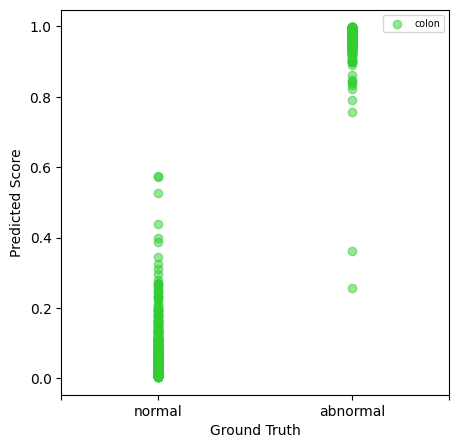

In [16]:
# train
color_list = ['limegreen', 'blueviolet', 'orange', 'lightsteelblue']
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

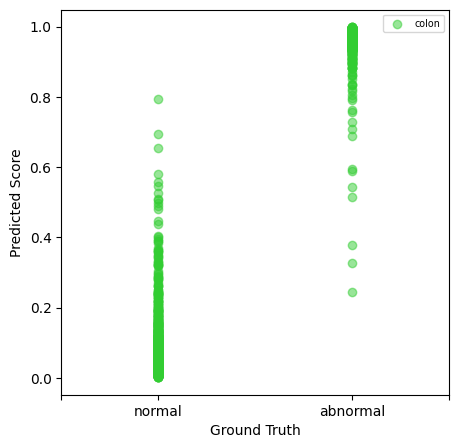

In [17]:
# test 
color_list = ['limegreen', 'blueviolet', 'orange', 'lightsteelblue']
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

##### (2) qhat

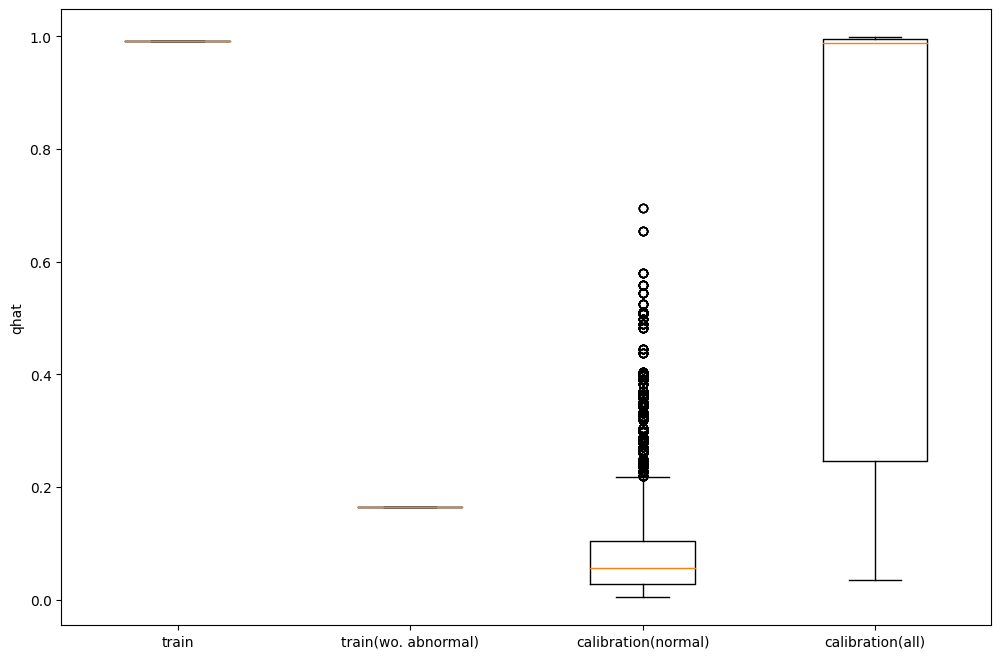

In [18]:
plt.figure(figsize=(12, 8))
plt.boxplot([train_qhat, train_qhat_wo_n, normal_all_qhat,  all_all_qhat])
plt.xticks([1, 2, 3, 4 ], ['train',  'train(wo. abnormal)', 'calibration(normal)', 'calibration(all)'])
plt.ylabel('qhat')
plt.show()

---
# 5. conformal p-value

#### 4. Computing marginal conformal p-values

In [19]:
from cccpv.models import ToyModel
from cccpv.methods import ConformalPvalues
from cccpv.methods import calibrate_ccv

In [20]:
scores_test = 1- np.array(y_score_list)
scores_cal = 1 - np.array(scores)

scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

In [31]:
pvals_marginal

array([0.00199601, 0.00199601, 0.00199601, ..., 0.01596806, 0.91616766,
       0.9241517 ])

In [22]:
is_outlier = np.zeros(len(scores_test))
is_outlier[np.where(y_true_np == 1)[0]] = 1
print(np.where(y_true_np == 1)[0])
print(is_outlier)

[   0    1    2 ... 1003 1004 1005]
[1. 1. 1. ... 0. 0. 0.]


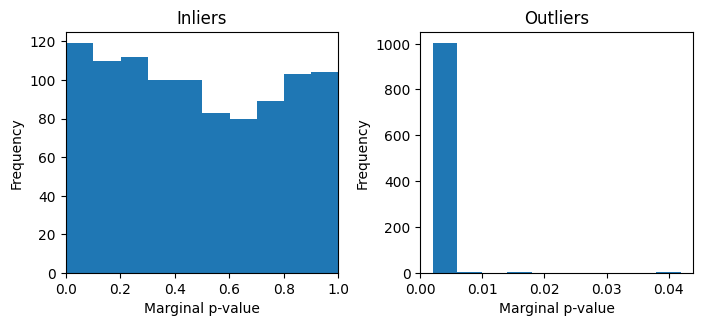

In [41]:
# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal[is_outlier==0])
axs[0].set_xlabel("Marginal p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal[is_outlier==1])
axs[1].set_xlabel("Marginal p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
# axs[1].set_xlim([0,0.1])

plt.show()

In [38]:
pred_pvals_marginal = pvals_marginal<0.05

p = precision_score(y_true_np, pred_pvals_marginal, zero_division=0)

r = recall_score(y_true_np, pred_pvals_marginal, zero_division=0)

print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.934
recall: 1.0


In [44]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')
normal_all_qhat = []
alpha = 0.1

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1-np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        y_pred = pvals_marginal < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal[y_label==0])
        axs[0].set_xlabel("Marginal p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal[y_label==1])
        axs[1].set_xlabel("Marginal p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./cal_p_medical/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 1000 
전체개수 ===> 2006 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.6979 
recall: 0.9999


---25---
precision: 0.6989 
recall: 0.9999


---30---
precision: 0.6999 
recall: 0.9999


---35---
precision: 0.7009 
recall: 0.9999


---40---
precision: 0.7019 
recall: 0.9999


---45---
precision: 0.7029 
recall: 0.9999


---50---
precision: 0.7039 
recall: 0.9999


---55---
precision: 0.7049 
recall: 0.9999




##### Benjamini-Hochberg 

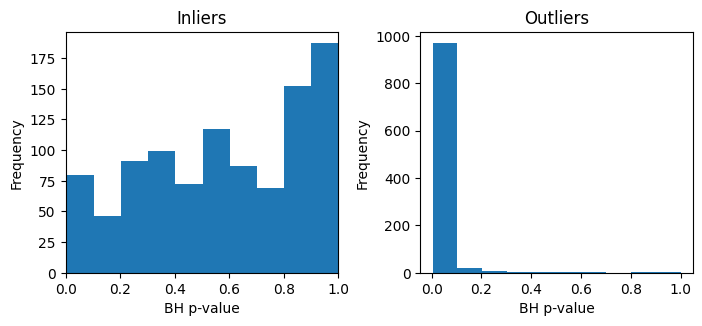

In [43]:
pvals_marginal_sorted = np.sort(pvals_marginal)
m = len(pvals_marginal)

pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))
# pvals_marginal_bh = pvals_marginal_sorted * (m / np.arange(1, m + 1))

pvals_marginal_bh_full = np.empty_like(pvals_marginal)
pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal_bh_full[is_outlier==0])
axs[0].set_xlabel("BH p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal_bh_full[is_outlier==1])
axs[1].set_xlabel("BH p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
# axs[1].set_xlim([0,1])

plt.show()

In [40]:
pred_marginal_bh_full = pvals_marginal_bh_full<0.05

p = precision_score(y_true_np, pred_marginal_bh_full, zero_division=0)

r = recall_score(y_true_np, pred_marginal_bh_full, zero_division=0)

print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.95
recall: 0.919


In [45]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')
normal_all_qhat = []
alpha = 0.1

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1-np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        pvals_marginal_sorted = np.sort(pvals_marginal)
        m = len(pvals_marginal)

        pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))
        # pvals_marginal_bh = pvals_marginal_sorted * (m / np.arange(1, m + 1))

        pvals_marginal_bh_full = np.empty_like(pvals_marginal)
        pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

        y_pred = pvals_marginal_bh_full < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal_bh_full[y_label==0])
        axs[0].set_xlabel("BH p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal_bh_full[y_label==1])
        axs[1].set_xlabel("BH p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./bh_p_medical/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 1000 
전체개수 ===> 2006 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.0 
recall: 0.0


---25---
precision: 0.0073 
recall: 0.0025


---30---
precision: 0.026 
recall: 0.0091


---35---
precision: 0.0553 
recall: 0.0159


---40---
precision: 0.1491 
recall: 0.0466


---45---
precision: 0.3178 
recall: 0.153


---50---
precision: 0.4032 
recall: 0.2374


---55---
precision: 0.4583 
recall: 0.308




#### 6. Numerical experiments


In [26]:
# from utils_experiments import evaluate_all_methods

# def run_experiment(model, method_oneclass, alpha=0.1, random_state=2021, purity=0.9, num_test=10):   
#     # Sample training data
#     data, _ = model.sample(n, random_state=random_state)

#     # Initialize the one-class classifier
#     contamination = 0.001
#     contamination = min(max(contamination,0.004),0.1)
#     if method_oneclass == "SVM":
#         classifier = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
#     if method_oneclass == "IForest":
#         classifier = IsolationForest(random_state=random_state, contamination=contamination, behaviour="new")
#     if method_oneclass == "Neighbors":
#         classifier = LocalOutlierFactor(novelty=True, contamination=contamination)
        
#     # Calibrate the conformal classifier
#     cc = ConformalPvalues(data, classifier, calib_size=0.5, delta = 0.05, random_state=random_state)

#     # Evaluate performance on test data
#     results = pd.DataFrame({})
#     for test_index in range(num_test):
#         # Sample test data
#         random_state_new = random_state + 10000 * test_index
#         data_test, is_outlier = model.sample(n, purity=purity, random_state=random_state_new)
        
#         # Compute p-values on test data
#         pvals_one_class = cc.predict(data_test, simes_kden=2)

#         # Evaluate performance
#         res = evaluate_all_methods(pvals_one_class, is_outlier, alpha=alpha)

#         # Store results
#         res['Amplitude'] = model.a
#         res['Data-index'] = random_state
#         res['Test-index'] = test_index
#         results = pd.concat([results, res])
    
#     return results

In [27]:
# num_data = 100 # Number of data sets to simulate
# num_test = 10  # Number of test sets to simulate for each data set
# purity = 0.9   # Proportion of outliers in test data
# a = 2.5        # Outlier signal strength

# # Initialize data model
# model = ToyModel(p, a)

# # Choose a one-class classifier algorithm
# method_oneclass = "SVM"

# # Run all the experiments
# results = pd.DataFrame({})
# for train_index in tqdm(range(num_data)):
#     res = run_experiment(model, method_oneclass, random_state=train_index, purity=purity, num_test=num_test)
#     results = pd.concat([results, res])